## Лабораторна робота №2 з дисципліни "Машинне навчання"
### Виконав: Студент групи КМ-12 Пєшков Антон

**Порядок виконання завдання:**
1. Відкрити та зчитати дані з наданого файлу.
2. Визначити збалансованість набору даних. Вивести кількість об’єктів кожного класу.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('KM-12-2.csv')
display(df)
df.GT.value_counts()

,GT,Model_1_0,Model_1_1,Model_2_0,Model_2_1
0,1,0.133871,0.866129,0.265398,0.734602
1,1,0.707424,0.292576,0.894910,0.105090
2,1,0.355263,0.644737,0.957991,0.042009
3,1,0.674354,0.325646,0.060504,0.939496
4,1,0.674354,0.325646,0.991170,0.008830
...,...,...,...,...,...
4995,0,0.417549,0.582451,0.983547,0.016453
4996,0,0.828717,0.171283,0.010689,0.989311
4997,0,0.707424,0.292576,0.974684,0.025316
4998,0,0.840336,0.159664,0.950068,0.049932


GT
1    2500
0    2500
Name: count, dtype: int64

3. Для зчитаного набору даних виконати наступні дії: 
    1. Обчислити всі метрики:
        - Accuracy;
        - Precision;
        - Recall;
        - F-Score;
        - Matthews Correlation Coefficient;
        - Balanced Accuracy;
        - Youden’s J statistics;
        - Area Under Curve for Precision-Recall Curve;
        - Area Under Curve for Receiver Operation Curve,

        для кожної моделі при різних значеннях порогу класифікатора (крок зміни порогу обрати самостійно). 
    2. Збудувати на одному графіку в одній координатній системі (величина порогу; значення метрики) графіки усіх обчислених метрик, відмітивши певним чином максимальне значення кожної з них.
    3. Збудувати в координатах (значення оцінки класифікаторів; кількість об’єктів кожного класу) окремі для кожного класу графіки кількості об’єктів та відмітити вертикальними лініями оптимальні пороги відсічення для кожної метрики.
    4. Збудувати для кожного класифікатору $PR$-криву та $ROC$-криву, показавши графічно на них значення оптимального порогу.

In [18]:
from matplotlib.axes import Axes


_ArrayLike = list[float]
TITLEFONT = {'size': 20}
LABELFONT = {'size': 18}
LEGENDCFG = dict(fontsize=14, loc='upper left', bbox_to_anchor=(1.0, 1))


class Plotter:
    def __init__(self, col_true: pd.Series, col_model_1: pd.Series):
        assert col_true.shape == col_model_1.shape, "Shapes must be equal"

        self.true_val = col_true
        self.model = col_model_1

    def build_metrics(self, threshold: _ArrayLike, beta: float = 1):
        # Construct initial dataframe, build confusion matrix
        df = pd.DataFrame.from_dict({'Threshold': threshold})
        df[['TP', 'TN', 'FP', 'FN']] = [
            (
                (self.true_val & (self.model > p)).sum(),
                ((~self.true_val) & (self.model <= p)).sum(),
                ((~self.true_val) & (self.model > p)).sum(),
                (self.true_val & (self.model <= p)).sum()
            )
            for p in df['Threshold']
        ]
        TP, TN, FP, FN = df.TP, df.TN, df.FP, df.FN
        # M  \ T 1  0
        # 1      TP FP
        # 0      FN TN

        df['Accuracy'] = (TP + TN)/(TP + TN + FP + FN)
        PRECISION = df['Precision'] = TP/(TP + FP)
        RECALL_0 = df['Recall_0'] = TN/(TN + FP)
        RECALL_1 = df['Recall_1'] = TP/(TP + FN)
        df['F-score'] = (1 + beta**2)*PRECISION*RECALL_1 \
            /(beta**2*PRECISION + RECALL_1)
        df['MCC'] = (TP*TN - FP*FN) \
            / ((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))**(1/2)
        df['Bal. Accuracy'] = (RECALL_0 + RECALL_1)/2
        df['J-statistic'] = RECALL_0 + RECALL_1 - 1

        display(df)
        self.metrics = df

    def visualize_metrics(self, title: str, labels: list[str]):
        df = self.metrics
        ps = df['Threshold']

        # The line plot of metrics depending on threshold
        plot = df.plot
        ax = plot.line('Threshold', labels)

        # The maximum points
        max_pts = pd.DataFrame.from_dict({
            label: (ps[idmax], df[label][idmax])
            for label, idmax in zip(labels, df[labels].idxmax())
        }, 'columns')
        max_pts.transpose().plot.scatter(0, 1, ax=ax.axes, s=7**2, zorder=5)
        display(max_pts)

        # Plotting
        ax.figure.set_size_inches(10, 8)
        ax.set_title(title, TITLEFONT)
        ax.set_xlabel("Поріг класифікатора p", LABELFONT)
        ax.set_ylabel("Значення метрики", LABELFONT)
        ax.legend(**LEGENDCFG)
        plt.show()

    def visualize_optimal_threshold(self, title: str):
        # Computing improvised parameter of quality,
        # TP + TN v FP + FN in this case
        df = self.metrics[['Threshold', 'TP', 'TN', 'FP', 'FN']].copy()
        df['T'] = df['TP'] + df['TN']
        df['F'] = df['FP'] + df['FN']
        df['Diff'] = df['T'] - df['F']

        i_mx = df['Diff'].idxmax()
        x_mx = df['Threshold'][i_mx]
        print(f"Оптимальний поріг класифікатора: {x_mx:.4f}, "
              f"різниця значень: {df['Diff'][i_mx]}")

        # Plotting
        ax = df[['Threshold', 'T', 'F']].plot.line('Threshold')
        ax.vlines([x_mx], 0, max(df['T'][i_mx], df['F'][i_mx]), colors=['red'])

        ax.figure.set_size_inches(10, 8)
        ax.set_title(title, TITLEFONT)
        ax.set_xlabel("Поріг класифікатора p", LABELFONT)
        ax.set_ylabel("Кількість об'єктів", LABELFONT)
        ax.legend(["Правильно визначені об'єкти",
                   "Неправильно визначені об'єкти",
                   "Оптимальний поріг"],
                  **LEGENDCFG)
        plt.show()

    def _auc(self, frame: pd.DataFrame, x: str, y: str):
        sum = 0
        it = frame.iterrows()
        _, row = next(it)
        x0, y0 = row[x], row[y]
        for _, row in it:
            x1, y1 = row[x], row[y]
            sum += (x1 - x0)*(y0 + y1)/2
            x0, y0 = x1, y1
        return sum

    def visualize_prc_roc(self):
        fig, [ax_left, ax_right] = plt.subplots(1, 2)
        self._visualize_prc(ax_left)
        self._visualize_roc(ax_right)
        fig.set_size_inches(12, 9)
        plt.show()

    def _visualize_prc(self, ax_orig: Axes):
        # Replace nan in first cell with expected 1
        pr = self.metrics[['Precision', 'Recall_1']]\
            .copy()\
            .drop_duplicates()\
            .rename(columns={'Recall_1': 'Recall'})\
            .replace(np.nan, 1)\
            .sort_values('Recall', ascending=True)

        ax = pr.plot.area('Recall', color='#0547af', stacked=False, ax=ax_orig)

        auc = self._auc(pr, 'Recall', 'Precision')
        ax.text(0.5, 0.25, f'AUC PRC = {auc:.3f}', horizontalalignment='center',
                color='white', size=20, weight='bold')

        optimal = min(((i, a['Precision'], a['Recall'])
                       for i, a in pr.iterrows()),
                      key=lambda tup: (1 - tup[1])**2 + (1 - tup[2])**2)
        threshold = self.metrics.loc[optimal[0]]['Threshold']

        print("Для PR-кривої маємо опт. значення "
              "за критерієм відстані до (1; 1)\n"
              "у т. ({0:.4f}; {1:.4f}), значення порогу {2}"
              .format(*optimal[1:], threshold))

        ax.scatter([optimal[2]], [optimal[1]], color='red', s=7**2, zorder=5)

        ax.set_title("PR-крива")
        ax.set_xlabel("Recall", **LABELFONT)
        ax.set_ylabel("Precision", **LABELFONT)
        dlt = 0.03
        ax.set_xlim(-dlt, 1 + dlt)
        ax.set_ylim(-dlt, 1 + dlt)
        ax.set_aspect('equal')
        ax.get_legend().remove()

    def _visualize_roc(self, ax_orig: Axes):
        df = self.metrics[['TP', 'FP', 'TN', 'FN']].copy().drop_duplicates()
        df = df.assign(FPR=df['FP']/(df['FP'] + df['TN']),
                    TPR=df['TP']/(df['TP'] + df['FN']))\
            .sort_values('FPR', ascending=True)

        ax = df.plot.line('FPR', 'TPR', ax=ax_orig)

        auc = self._auc(df, 'FPR', 'TPR')

        optimal = min(((i, a['FPR'], a['TPR'])
                       for i, a in df[['FPR', 'TPR']].iterrows()),
                      key=lambda tup: tup[1]**2 + (1 - tup[2])**2)
        threshold = self.metrics.loc[optimal[0]]['Threshold']

        print("Для ROC-кривої маємо опт. значення "
              "за критерієм відстані до (0; 1)\n"
              "у т. ({0:.4f}; {1:.4f}), значення порогу {2}"
              .format(*optimal[1:], threshold))

        ax.scatter([optimal[1]], [optimal[2]], color='red', s=7**2, zorder=5)

        ax.text(0.5, 0.25, f'AUC ROC = {auc:.3f}', horizontalalignment='center',
                color='black', size=20, weight='bold')

        ax.set_title("ROC-крива")
        ax.set_xlabel("FPR", **LABELFONT)
        ax.set_ylabel("TPR", **LABELFONT)
        dlt = 0.03
        ax.set_xlim(-dlt, 1 + dlt)
        ax.set_ylim(-dlt, 1 + dlt)
        ax.set_aspect('equal')
        ax.get_legend().remove()

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall_0,Recall_1,F-score,MCC,Bal. Accuracy,J-statistic
0,-0.0001,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
1,0.0100,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
2,0.0200,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
3,0.0300,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
4,0.0400,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.9600,608,2492,8,1892,0.6200,0.987013,0.9968,0.2432,0.390244,0.365112,0.6200,0.2400
97,0.9700,509,2495,5,1991,0.6008,0.990272,0.9980,0.2036,0.337757,0.331909,0.6008,0.2016
98,0.9800,509,2495,5,1991,0.6008,0.990272,0.9980,0.2036,0.337757,0.331909,0.6008,0.2016
99,0.9900,170,2500,0,2330,0.5340,1.000000,1.0000,0.0680,0.127341,0.187608,0.5340,0.0680


,Accuracy,Precision,Recall_1,F-score,MCC,J-statistic,Bal. Accuracy
0,0.5300,0.99,-0.0001,0.400000,0.530000,0.5300,0.5300
1,0.7734,1.00,1.0000,0.764511,0.548403,0.5468,0.7734


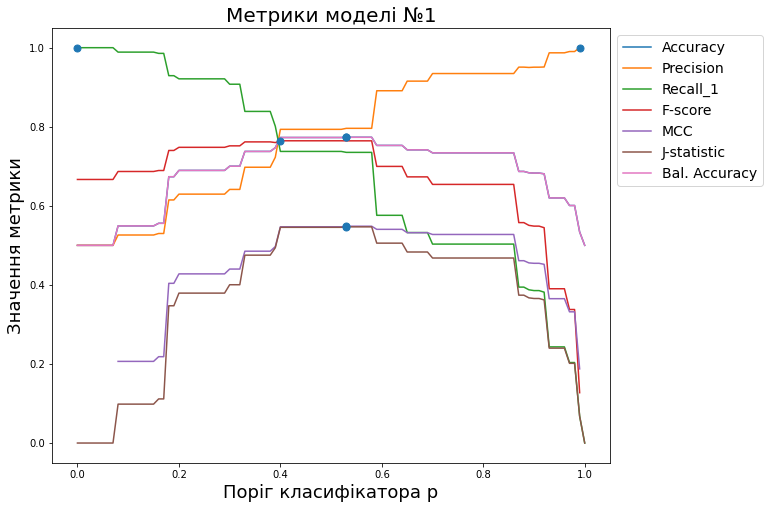

Оптимальний поріг класифікатора: 0.5300, різниця значень: 2734


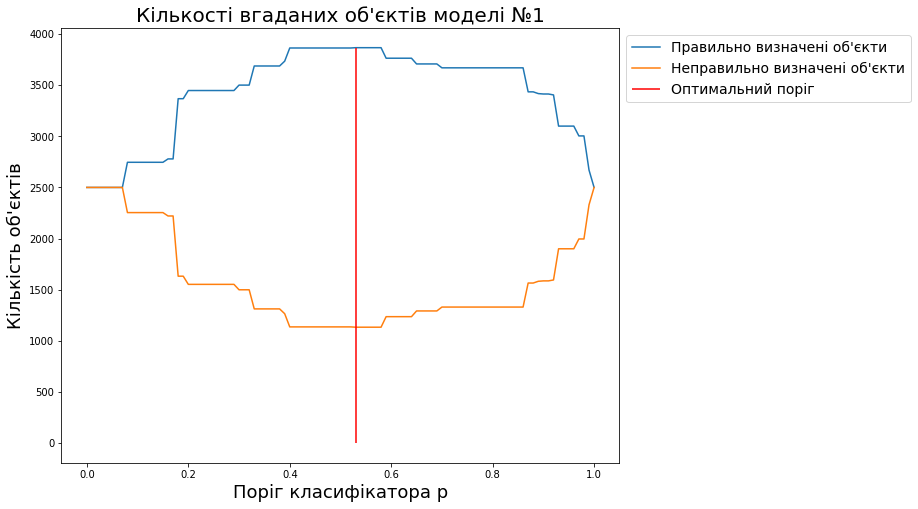

Для PR-кривої маємо опт. значення за критерієм відстані до (1; 1)
у т. (0.7935; 0.7376), значення порогу 0.4
Для ROC-кривої маємо опт. значення за критерієм відстані до (0; 1)
у т. (0.1884; 0.7352), значення порогу 0.53


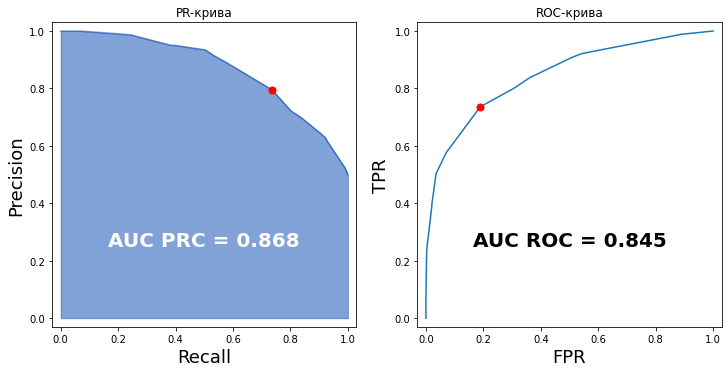

In [19]:
N = 100
thresholds = [step/N for step in range(N + 1)]
# Account for values with P(is <type 1>) = 0
thresholds[0] -= 0.0001
labels = ['Accuracy', 'Precision', 'Recall_1', 'F-score', 'MCC', 'J-statistic',
          'Bal. Accuracy']

plotter1 = Plotter(df['GT'], df['Model_1_1'])
plotter1.build_metrics(thresholds)
plotter1.visualize_metrics('Метрики моделі №1', labels)
plotter1.visualize_optimal_threshold("Кількості вгаданих об'єктів моделі №1")
plotter1.visualize_prc_roc()

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall_0,Recall_1,F-score,MCC,Bal. Accuracy,J-statistic
0,-0.0001,2500,0,2500,0,0.5000,0.500000,0.0000,1.0000,0.666667,NaN,0.5000,0.0000
1,0.0100,2299,790,1710,201,0.6178,0.573460,0.3160,0.9196,0.706407,0.295502,0.6178,0.2356
2,0.0200,2070,1272,1228,430,0.6684,0.627653,0.5088,0.8280,0.714039,0.355391,0.6684,0.3368
3,0.0300,1948,1467,1033,552,0.6830,0.653472,0.5868,0.7792,0.710819,0.372968,0.6830,0.3660
4,0.0400,1861,1564,936,639,0.6850,0.665356,0.6256,0.7444,0.702662,0.372639,0.6850,0.3700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.9600,815,2404,96,1685,0.6438,0.894621,0.9616,0.3260,0.477866,0.372530,0.6438,0.2876
97,0.9700,801,2414,86,1699,0.6430,0.903044,0.9656,0.3204,0.472985,0.374339,0.6430,0.2860
98,0.9800,788,2420,80,1712,0.6416,0.907834,0.9680,0.3152,0.467933,0.373846,0.6416,0.2832
99,0.9900,760,2436,64,1740,0.6392,0.922330,0.9744,0.3040,0.457280,0.375202,0.6392,0.2784


,Accuracy,Precision,Recall_1,F-score,MCC,J-statistic,Bal. Accuracy
0,0.06,0.99000,-0.0001,0.020000,0.060000,0.06,0.06
1,0.69,0.92233,1.0000,0.714039,0.380006,0.38,0.69


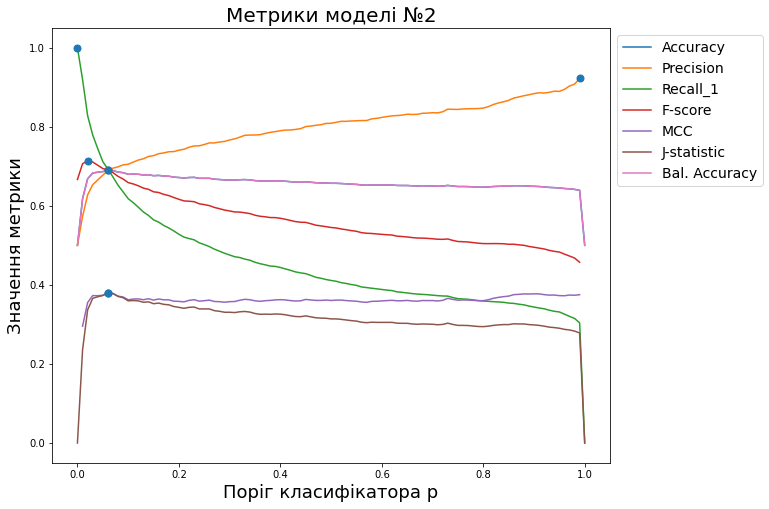

Оптимальний поріг класифікатора: 0.0600, різниця значень: 1900


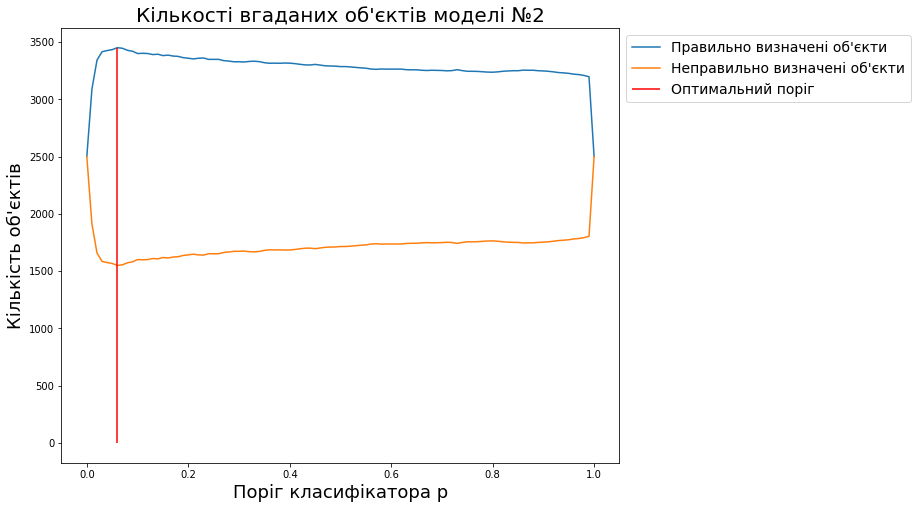

Для PR-кривої маємо опт. значення за критерієм відстані до (1; 1)
у т. (0.6277; 0.8280), значення порогу 0.02
Для ROC-кривої маємо опт. значення за критерієм відстані до (0; 1)
у т. (0.3128; 0.6928), значення порогу 0.06


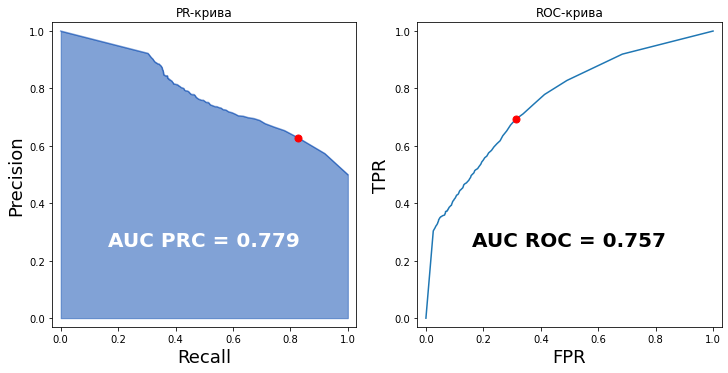

In [20]:
plotter2 = Plotter(df['GT'], df['Model_2_1'])
plotter2.build_metrics(thresholds)
plotter2.visualize_metrics('Метрики моделі №2', labels)
plotter2.visualize_optimal_threshold("Кількості вгаданих об'єктів моделі №2")
plotter2.visualize_prc_roc()

4. Зробити висновки щодо якості моделей, визначити кращу модель.
5. Створити новий набір даних, прибравши з початкового  набору $ (50 + 5К)\% $ об’єктів класу 1, вибраних випадковим чином. Параметр К представляє собою залишок від ділення дня народження студента на дев’ять та має визначатися в програмі на основі дати народження студента, яка задана в програмі у вигляді текстової змінної формату ‘DD-MM’. 
6. Вивести відсоток видалених об’єктів класу 1 та кількість елементів кожного класу після видалення. 

In [21]:
DATE = '09-05'
K = int(DATE[:2]) % 9

sample = df[df['GT'] == 1].sample(frac=(50 + 5*K)/100)
print(f"К-сть видалених об'єктів класу 1: {(50 + 5*K)/100:.1%}")
df2 = df.drop(index=sample.index)
print(df2['GT'].value_counts())

К-сть видалених об'єктів класу 1: 50.0%
GT
0    2500
1    1250
Name: count, dtype: int64


7. Виконати дії п.3 для нового набору даних.

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall_0,Recall_1,F-score,MCC,Bal. Accuracy,J-statistic
0,-0.0001,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
1,0.0100,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
2,0.0200,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
3,0.0300,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
4,0.0400,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.9600,324,2492,8,926,0.750933,0.975904,0.9968,0.2592,0.409608,0.424825,0.6280,0.2560
97,0.9700,278,2495,5,972,0.739467,0.982332,0.9980,0.2224,0.362688,0.393339,0.6102,0.2204
98,0.9800,278,2495,5,972,0.739467,0.982332,0.9980,0.2224,0.362688,0.393339,0.6102,0.2204
99,0.9900,98,2500,0,1152,0.692800,1.000000,1.0000,0.0784,0.145401,0.231666,0.5392,0.0784


,Accuracy,Precision,Recall_1,F-score,MCC,J-statistic,Bal. Accuracy
0,0.590000,0.99,-0.0001,0.530000,0.590000,0.5300,0.5300
1,0.822133,1.00,1.0000,0.708927,0.584915,0.5676,0.7838


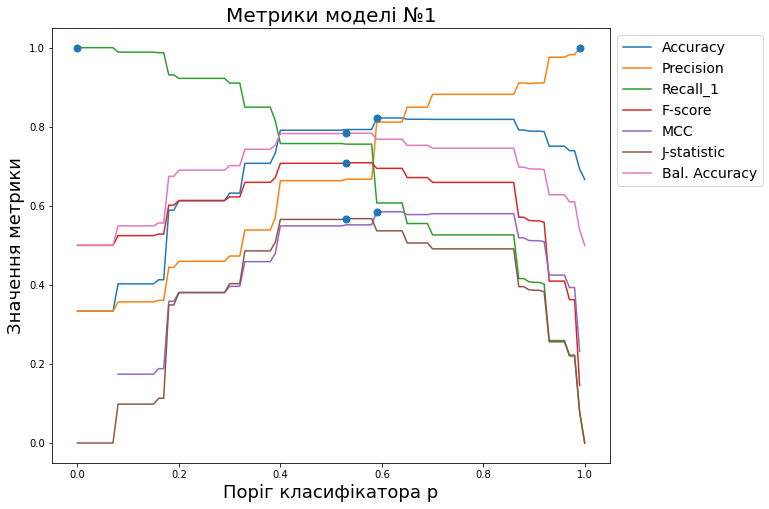

Оптимальний поріг класифікатора: 0.5900, різниця значень: 2416


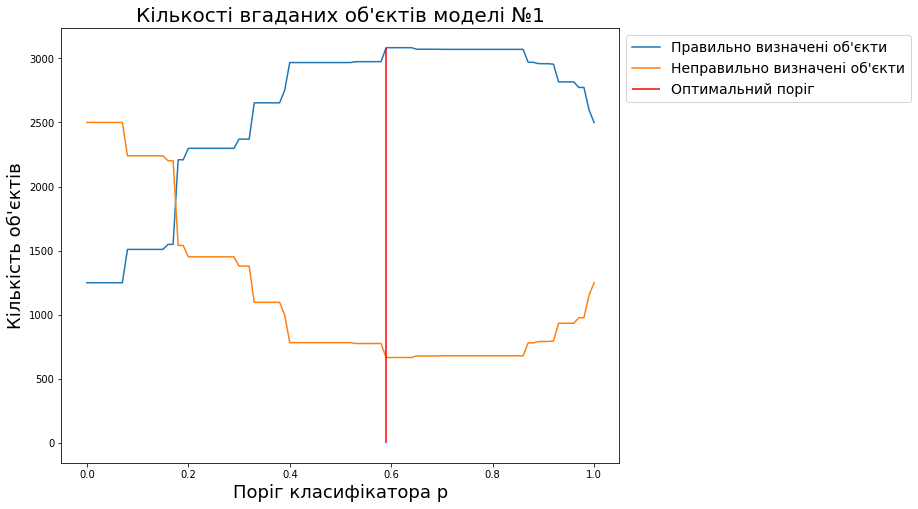

Для PR-кривої маємо опт. значення за критерієм відстані до (1; 1)
у т. (0.6674; 0.7560), значення порогу 0.53
Для ROC-кривої маємо опт. значення за критерієм відстані до (0; 1)
у т. (0.1884; 0.7560), значення порогу 0.53


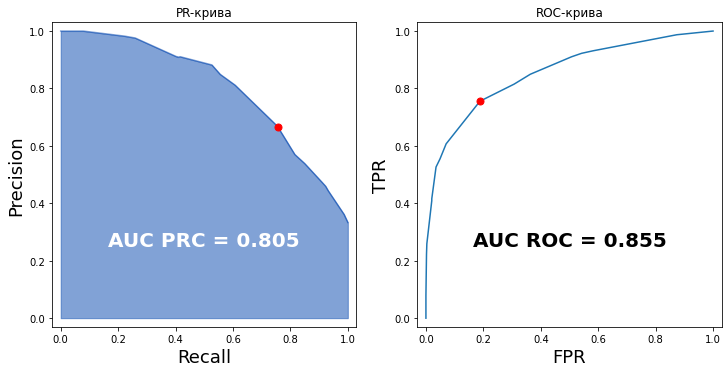

In [22]:
plotter1 = Plotter(df2['GT'], df2['Model_1_1'])
plotter1.build_metrics(thresholds)
plotter1.visualize_metrics('Метрики моделі №1', labels)
plotter1.visualize_optimal_threshold("Кількості вгаданих об'єктів моделі №1")
plotter1.visualize_prc_roc()

,Threshold,TP,TN,FP,FN,Accuracy,Precision,Recall_0,Recall_1,F-score,MCC,Bal. Accuracy,J-statistic
0,-0.0001,1250,0,2500,0,0.333333,0.333333,0.0000,1.0000,0.500000,NaN,0.5000,0.0000
1,0.0100,1159,790,1710,91,0.519733,0.403974,0.3160,0.9272,0.562758,0.270418,0.6216,0.2432
2,0.0200,1047,1272,1228,203,0.618400,0.460220,0.5088,0.8376,0.594043,0.334284,0.6732,0.3464
3,0.0300,990,1467,1033,260,0.655200,0.489372,0.5868,0.7920,0.604950,0.358254,0.6894,0.3788
4,0.0400,951,1564,936,299,0.670667,0.503975,0.6256,0.7608,0.606312,0.364309,0.6932,0.3864
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.9600,415,2404,96,835,0.751733,0.812133,0.9616,0.3320,0.471323,0.403427,0.6468,0.2936
97,0.9700,409,2414,86,841,0.752800,0.826263,0.9656,0.3272,0.468768,0.407773,0.6464,0.2928
98,0.9800,404,2420,80,846,0.753067,0.834711,0.9680,0.3232,0.465975,0.409436,0.6456,0.2912
99,0.9900,390,2436,64,860,0.753600,0.859031,0.9744,0.3120,0.457746,0.413882,0.6432,0.2864


,Accuracy,Precision,Recall_1,F-score,MCC,J-statistic,Bal. Accuracy
0,0.900000,0.990000,-0.0001,0.060000,0.990000,0.0600,0.0600
1,0.754133,0.859031,1.0000,0.606788,0.413882,0.3952,0.6976


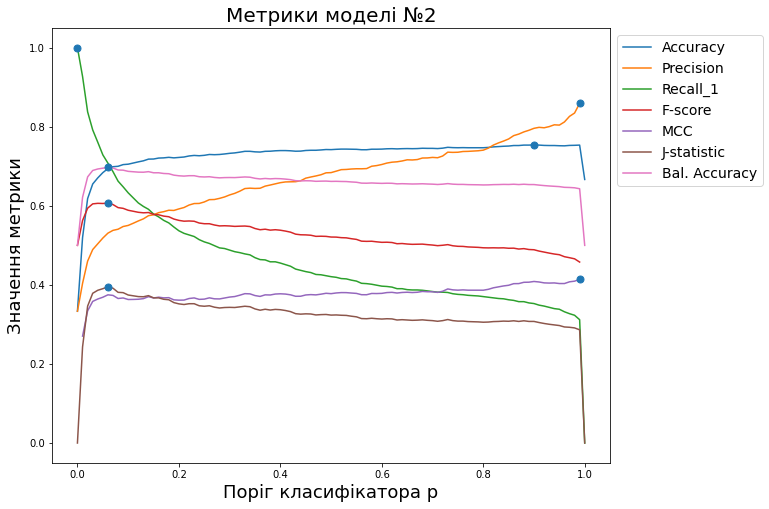

Оптимальний поріг класифікатора: 0.9000, різниця значень: 1906


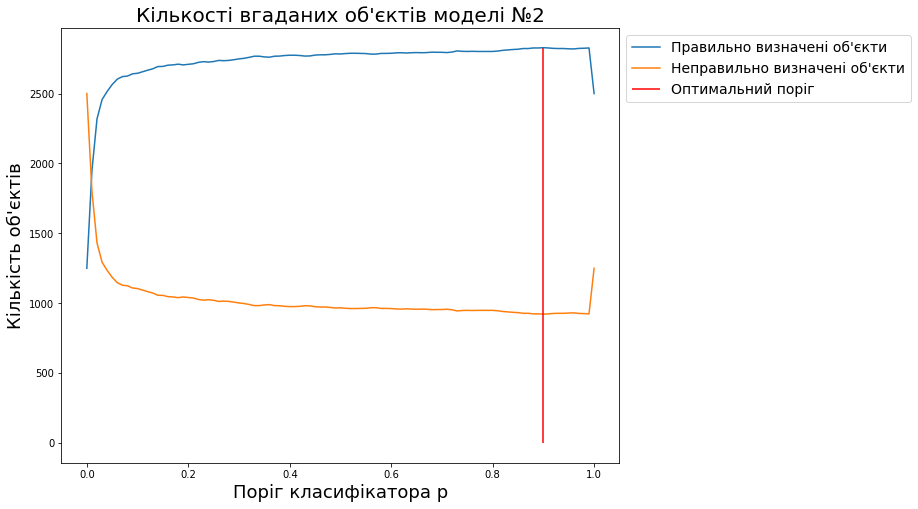

Для PR-кривої маємо опт. значення за критерієм відстані до (1; 1)
у т. (0.5040; 0.7608), значення порогу 0.04
Для ROC-кривої маємо опт. значення за критерієм відстані до (0; 1)
у т. (0.3128; 0.7080), значення порогу 0.06


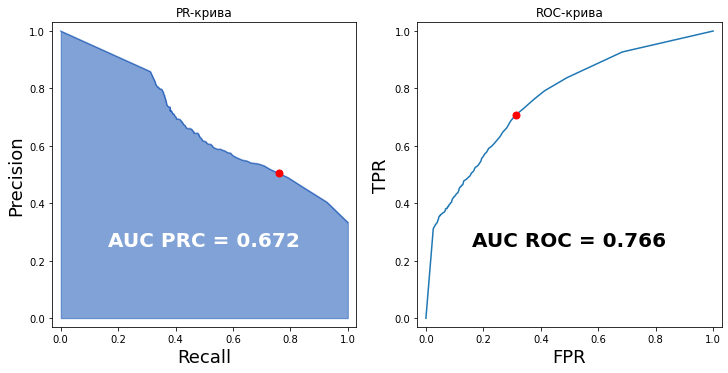

In [23]:
plotter2 = Plotter(df2['GT'], df2['Model_2_1'])
plotter2.build_metrics(thresholds)
plotter2.visualize_metrics('Метрики моделі №2', labels)
plotter2.visualize_optimal_threshold("Кількості вгаданих об'єктів моделі №2")
plotter2.visualize_prc_roc()

8. Визначити кращу модель.
9. Пояснити вплив незбалансованості набору даних на прийняте рішення.